# 1. Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython

# 2. Importing and visualizing data

### 2.1 Original features

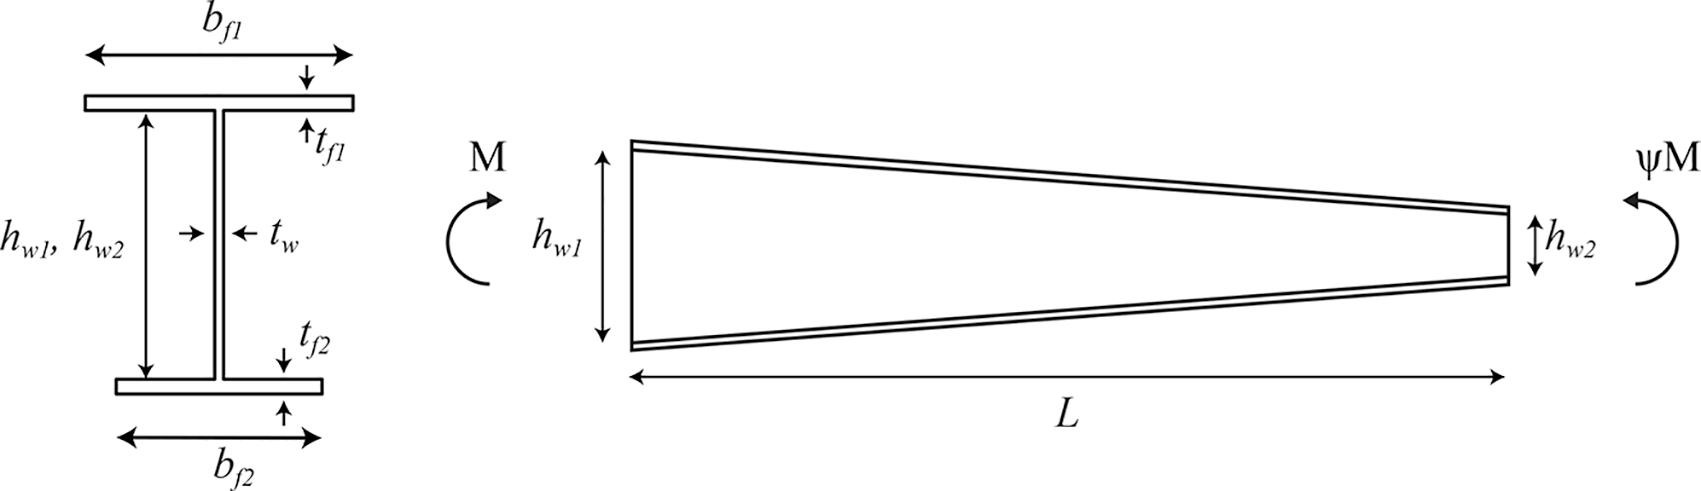

In [4]:
IPython.display.Image("1-s2.0-S2352012422004581-gr4_lrg.jpg")

In [5]:
df = pd.read_csv("training_set.csv", sep=';')
df_y_normalized = pd.read_csv("training_set_normalized.csv", sep = ";")
df["y_norm"] = df_y_normalized.y.copy()
display(df)

,hw1,hw2,tw,bf1,tf1,bf2,tf2,psi,L,y,y_norm
0,500,167,2.09,500,17.89,375,13.42,-0.75,19000,1703.681777,4.270872
1,700,280,4.75,525,34.26,700,40.53,-0.75,28000,6745.446061,2.496103
2,400,400,1.67,100,6.89,300,18.47,0.75,8000,143.526934,0.919286
3,160,400,3.43,200,9.37,100,6.89,-0.25,7200,145.486862,3.724770
4,100,400,1.33,300,15.16,300,4.11,1.00,5600,643.674997,1.521069
...,...,...,...,...,...,...,...,...,...,...,...
60544,1000,400,8.57,750,24.08,250,8.57,0.00,12000,15166.541030,7.885136
60545,900,900,6.11,225,17.17,675,34.11,1.00,18000,955.055842,0.625638
60546,400,100,1.67,300,18.47,100,7.26,-0.50,8000,1445.528301,10.890812
60547,200,600,6.97,450,34.34,150,9.24,0.50,8400,4352.341060,4.736697


In [6]:
df.info()
# All the variables are floats or integers.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60549 entries, 0 to 60548
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   hw1     60549 non-null  int64  
 1   hw2     60549 non-null  int64  
 2   tw      60549 non-null  float64
 3   bf1     60549 non-null  int64  
 4   tf1     60549 non-null  float64
 5   bf2     60549 non-null  int64  
 6   tf2     60549 non-null  float64
 7   psi     60549 non-null  float64
 8   L       60549 non-null  int64  
 9   y       60549 non-null  float64
 10  y_norm  60549 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 5.1 MB


In [7]:
df.isnull().sum()
# there are no NaN values

hw1       0
hw2       0
tw        0
bf1       0
tf1       0
bf2       0
tf2       0
psi       0
L         0
y         0
y_norm    0
dtype: int64

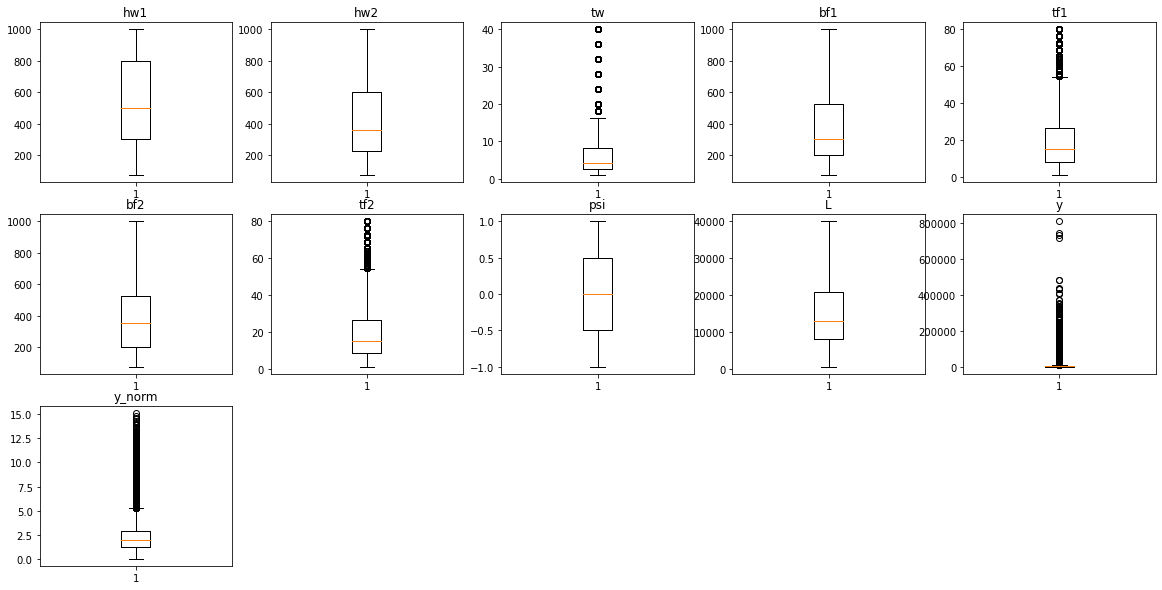

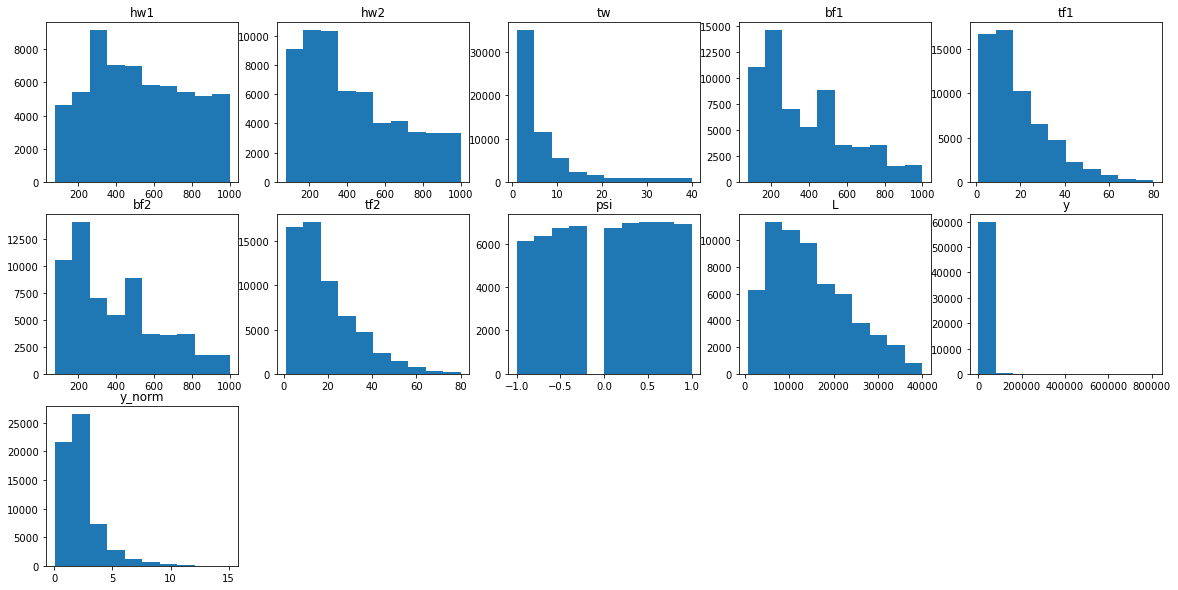

In [8]:
# Boxplots
plt.figure(figsize=(20,10))
for i in range(len(df.columns)):
    plt.subplot(3,5,i+1)
    plt.boxplot(df.iloc[:,i])
    plt.title(df.columns[i])

# Histograms
plt.figure(figsize=(20,10))
for i in range(len(df.columns)):
    plt.subplot(3,5,i+1)
    plt.hist(df.iloc[:,i])
    plt.title(df.columns[i])

# 3. Feature engineering

### 3.1 Eliminating samples with outliers in target variable

In [9]:
def df_outlier_elimination(df, target = "norm"):
    
    if target == "norm":
        y = df.copy().y_norm.values
    elif target == "original":
        y = df.copy().y.values
    else:
        print("error: type 'norm' or 'original', other input for <<target>> is not valid!")
    y_sort = np.sort(y)
    # quantiles
    Q1 = y_sort[round(len(y_sort)*0.25)]
    Q3 = y_sort[round(len(y_sort)*0.75)]
    # indices of outliers
    lower_indices = [i for i in range(len(y)) if y[i] < Q1-1.5*(Q3-Q1)]
    upper_indices = [i for i in range(len(y)) if y[i] > Q3+1.5*(Q3-Q1)]
    
    return df.copy().drop(index = lower_indices + upper_indices)

### 3.2 Generated features

- Taper ratio: $h_{w, max}/h_{w, min}$
- Flange width ratio: $b_{f1}/b_{f2}$
- Height to width ratio: $h_{w, max}/b_{f, max}$
- Beam length: $L/h_{w, max}$
- Plate thickness ratio: $t_{f1}/t_{w}; t_{f2}/t_{w}$
- Flange slenderness: $b_{f1}/t_{f1}; b_{f2}/t_{fs}$
- Web slenderness: $h_{w, max}/t_{w}$;

In [10]:
def df_extend(df):
    """
    this function creates new variables useful for the model
    these new variables are explained in the original paper
    """
    df_extended = df.copy()

    # creating new features
    df_extended["taper_ratio"] = df_extended[["hw1","hw2"]].max(axis=1) / df_extended[["hw1","hw2"]].min(axis=1)
    df_extended["flange_width_ratio"] = df_extended.bf1 / df_extended.bf2
    df_extended["height_to_width_ratio"] = df_extended[["hw1","hw2"]].max(axis=1) / df_extended[["bf1","bf2"]].max(axis=1)
    df_extended["beam_length"] = df_extended.L / df_extended[["hw1","hw2"]].max(axis=1)
    df_extended["plate_thickness_ratio_1"] = df_extended.tf1 / df_extended.tw
    df_extended["plate_thickness_ratio_2"] = df_extended.tf2 / df_extended.tw
    df_extended["flange_slenderness_1"] = df_extended.bf1 / df_extended.tf1
    df_extended["flange_slenderness_2"] = df_extended.bf2 / df_extended.tf2
    df_extended["web_slenderness"] = df_extended[["hw1", "hw2"]].max(axis=1) / df_extended.tw

    # change y and y_norm positions
    y_aux = df_extended.y
    y_norm_aux = df_extended.y_norm
    df_extended = df_extended.drop(columns=["y", "y_norm"])
    df_extended["y"] = y_aux
    df_extended["y_norm"] = y_norm_aux

    return df_extended

### 3.3 Plotting data with new features and filtered target

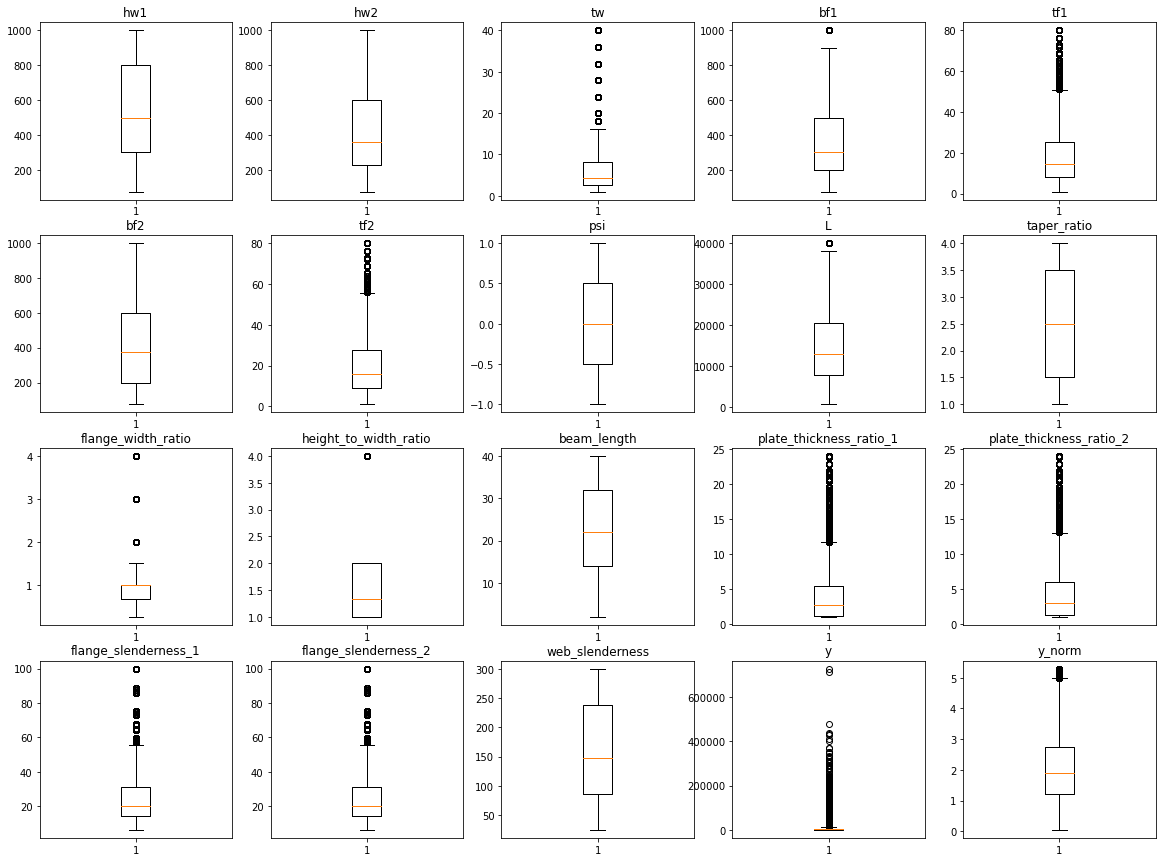

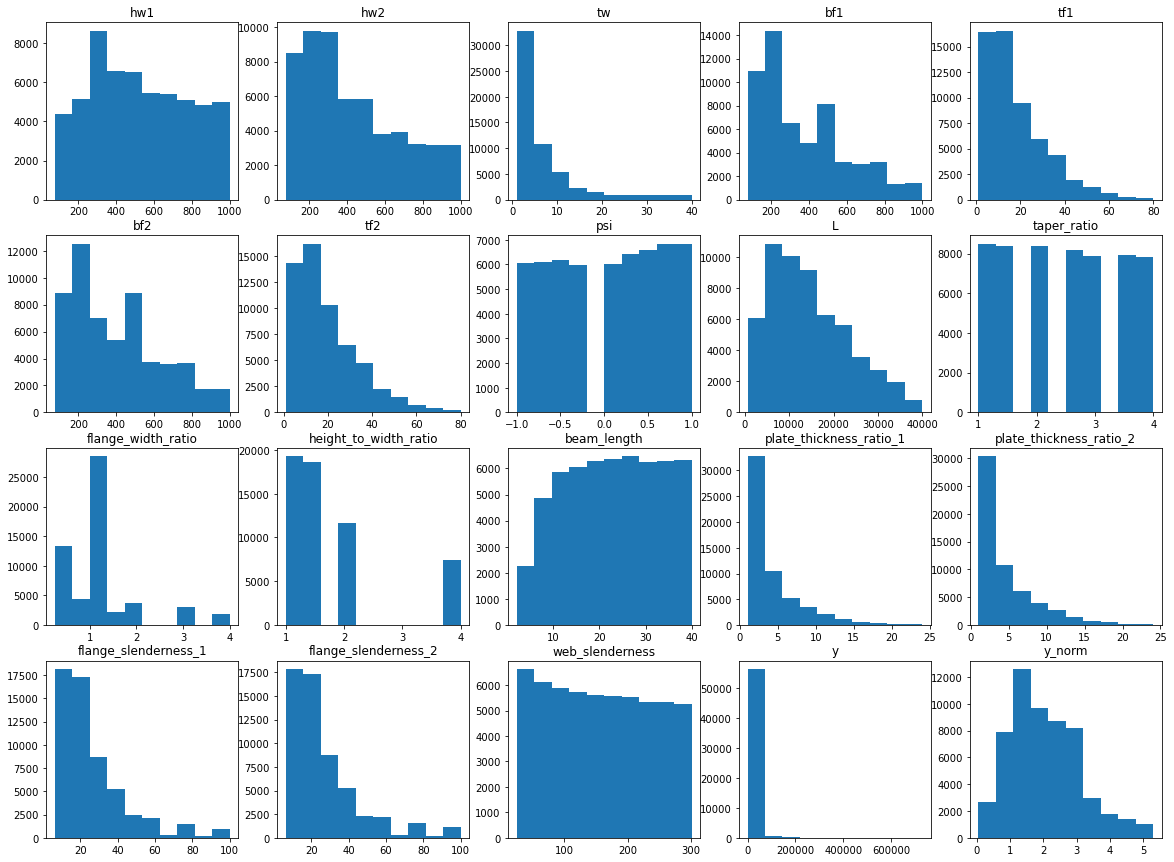

In [11]:
df_new = df_outlier_elimination(df_extend(df.copy()), target="norm")
%matplotlib inline
# Boxplots
plt.figure(figsize=(20,15))
for i in range(len(df_new.columns)):
    plt.subplot(4,5,i+1)
    plt.boxplot(df_new.iloc[:,i])
    plt.title(df_new.columns[i])

# Histograms
plt.figure(figsize=(20,15))
for i in range(len(df_new.columns)):
    plt.subplot(4,5,i+1)
    plt.hist(df_new.iloc[:,i])
    plt.title(df_new.columns[i])

### 3.4 Feature selection

Feature selection resorting to Lasso regression

In [12]:
def l1_feature_score(X, y):
    
    from sklearn.linear_model import Lasso
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import StandardScaler

    # scaling X
    X = StandardScaler().fit_transform(X)
    # potential alpha values
    parameters = {"alpha": [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.5, 1]}
    # grid search for best alpha
    clf = GridSearchCV(Lasso(), parameters)
    clf = clf.fit(X, y)
    alpha = clf.best_params_["alpha"]
    # feature scoring
    lasso = Lasso(alpha = alpha)
    lasso.fit(X, y)
    feature_score = lasso.coef_

    return feature_score

##### 3.4.1 Feature ranking 

Feature scoring through Lasso regression and L1 penalty

In [13]:
dataframe1 = df_extend(df.copy()) # with outliers
dataframe2 = df_outlier_elimination(df_extend(df.copy()), target='original')
dataframe3 = df_outlier_elimination(df_extend(df.copy()), target='norm')

# feature ranking with non-normalized y (with outliers)
features_score1 = l1_feature_score(dataframe1.iloc[:, :-2].values, dataframe1.y.values)

# feature ranking with non-normalized y (without outliers)
features_score2 = l1_feature_score(dataframe2.iloc[:, :-2].values, dataframe2.y.values)

# feature ranking with normalized y (with outliers)
features_score3 = l1_feature_score(dataframe1.iloc[:, :-2].values, dataframe1.y_norm.values)

# feature ranking with normalized y (without outliers)
features_score4 = l1_feature_score(dataframe3.iloc[:, :-2].values, dataframe3.y_norm.values)

Plotting the relative feature importance

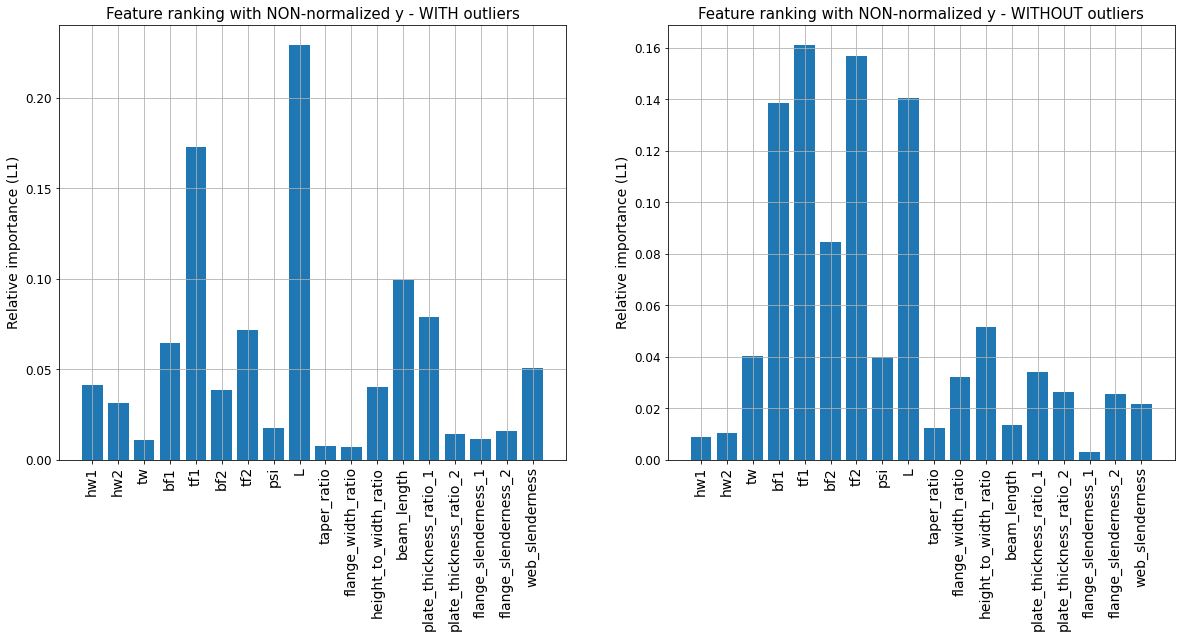

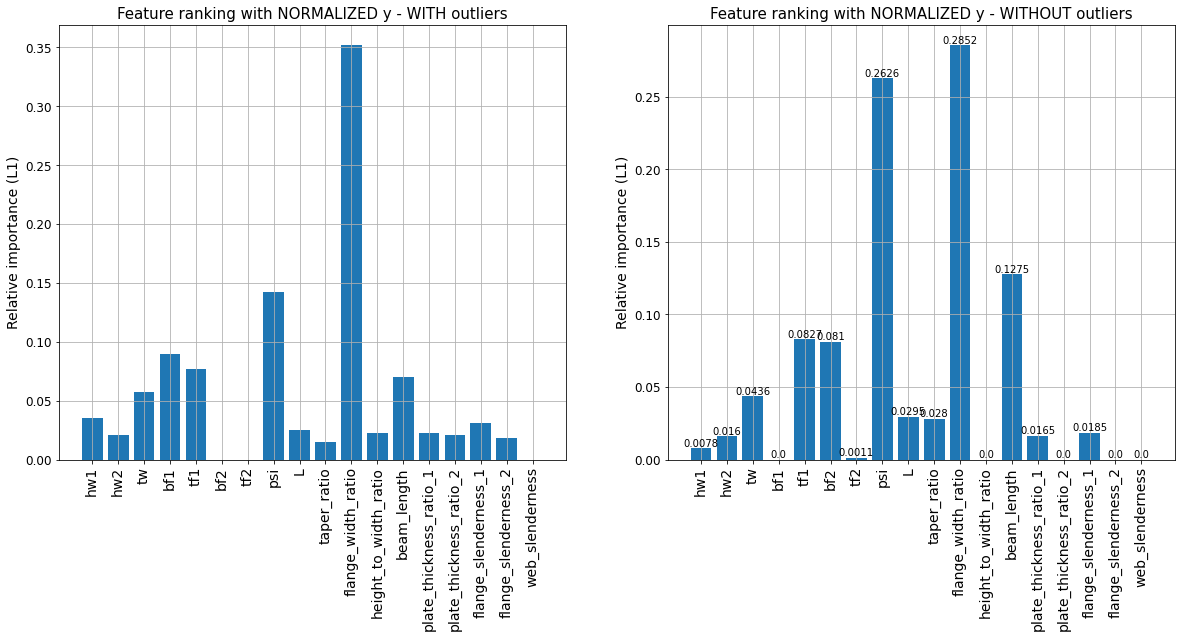

In [14]:
plt.figure(figsize=(20, 8))

# feature ranking with non-normalized y (with outliers)
plt.subplot(1, 2, 1)
plt.bar(x = dataframe1.columns[:-2], height = np.abs(features_score1)/np.sum(np.abs(features_score1)))
plt.xticks(rotation = 90, fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel("Relative importance (L1)", fontsize=14)
plt.title("Feature ranking with NON-normalized y - WITH outliers", fontsize=15)
plt.grid()

# feature ranking with non-normalized y (without outliers)
plt.subplot(1, 2, 2)
plt.bar(x = dataframe2.columns[:-2], height = np.abs(features_score2)/np.sum(np.abs(features_score2)))
plt.xticks(rotation = 90, fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel("Relative importance (L1)", fontsize=14)
plt.title("Feature ranking with NON-normalized y - WITHOUT outliers", fontsize=15)
plt.grid()

plt.show()

plt.figure(figsize=(20, 8))

# feature ranking with normalized y (with outliers)
plt.subplot(1, 2, 1)
plt.bar(x = dataframe1.columns[:-2], height = np.abs(features_score3)/np.sum(np.abs(features_score3)))
plt.xticks(rotation = 90, fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel("Relative importance (L1)", fontsize=14)
plt.title("Feature ranking with NORMALIZED y - WITH outliers", fontsize=15)
plt.grid()

# feature ranking with normalized y (without outliers)
plt.subplot(1, 2, 2)
bars = plt.bar(x = dataframe3.columns[:-2], height = np.abs(features_score4)/np.sum(np.abs(features_score4)))
plt.xticks(rotation = 90, fontsize=14)
plt.yticks(fontsize=12)
plt.ylabel("Relative importance (L1)", fontsize=14)
plt.title("Feature ranking with NORMALIZED y - WITHOUT outliers", fontsize=15)
plt.grid()

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, 
            bar.get_height(), 
            round(bar.get_height(), 4), 
            ha='center', va='bottom')

plt.show()


# 4. Automized version with sklearn

In [15]:
def modelAuto(df_train, df_test, PolyDegree, select_thresh = 0, alpha = 0.0001):

    import numpy as np
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.linear_model import Lasso
    from sklearn.model_selection import GridSearchCV
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error
    from sklearn.metrics import r2_score
    
    # eliminating target outliers and creating compound features
    train = df_extend(df_train.copy())
    train = df_outlier_elimination(train, target="norm")

    # arrays for training
    X_train = train.iloc[:, :-2].values
    y_train = train.y_norm.values

    # L1 feature selection
    FeatureScore = l1_feature_score(X_train, y_train)
    FeatureScore = np.abs(FeatureScore) / np.sum(np.abs(FeatureScore)) # relative importance
    FeatureIndex = np.argwhere(FeatureScore >= select_thresh)
    FeatureIndex = FeatureIndex.reshape((1, len(FeatureIndex)))
    print("Selected features:")
    print(list(train.columns[FeatureIndex[0]]))
    X_train_filt = X_train[:, FeatureIndex[0]]
        
    # polynomial features
    poly = PolynomialFeatures(degree = PolyDegree).fit(X_train_filt)
    X_train_poly = poly.transform(X_train_filt)

    # normalization
    scaler = StandardScaler()
    X_train_norm = scaler.fit_transform(X_train_poly)

    # linear regression
    if PolyDegree <= 4:
        regressor = LinearRegression()
    else:
        regressor = Lasso(alpha = alpha)
    regressor.fit(X_train_norm, y_train)

    # testing set
    test = df_extend(df_test.copy())

    # testing set transformations
    X_test = test.iloc[:, :-2].values
    y_test = test.y_norm.values
    X_test_filt = X_test[:, FeatureIndex[0]]
    X_test_poly = poly.transform(X_test_filt)
    X_test_norm = scaler.transform(X_test_poly)

    # predictions
    y_train_pred = regressor.predict(X_train_norm)
    y_test_pred = regressor.predict(X_test_norm)

    # mean absolute error
    print("Training MAE:", mean_absolute_error(y_train, y_train_pred))
    print("Testing MAE:", mean_absolute_error(y_test, y_test_pred))

    # coefficient of determination
    print("Training R^2:", r2_score(y_train, y_train_pred))
    print("Testing R^2:", r2_score(y_test, y_test_pred))

    plt.figure(figsize=(15,7))

    # Training results visualization
    plt.subplot(1, 2, 1)
    plt.scatter(MinMaxScaler().fit_transform(y_train.reshape(-1,1)), 
                MinMaxScaler().fit_transform(y_train_pred.reshape(-1,1)))
    plt.plot(range(2), range(2), color="black")
    plt.xlabel("y_true (normalized)", fontsize=12)
    plt.ylabel("y_pred (normalized)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title("Training data (poly="+str(PolyDegree)+"; thresh="+str(select_thresh)+")", fontsize=15)
    plt.grid()

    # Testing results visualization
    plt.subplot(1, 2, 2)
    plt.scatter(MinMaxScaler().fit_transform(y_test.reshape(-1,1)), 
                MinMaxScaler().fit_transform(y_test_pred.reshape(-1,1)))
    plt.plot(range(2), range(2), color="black")
    plt.xlabel("True (normalized)", fontsize=12)
    plt.ylabel("Prediction (normalized)", fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.title("Testing data (poly="+str(PolyDegree)+"; thresh="+str(select_thresh)+")", fontsize=15)
    plt.grid()

    plt.show()

    return regressor


Deployment (example)

Selected features:
['hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.543022521214684
Testing MAE: 0.7506559504618218
Training R^2: 0.48052089550216837
Testing R^2: 0.4499315932893483


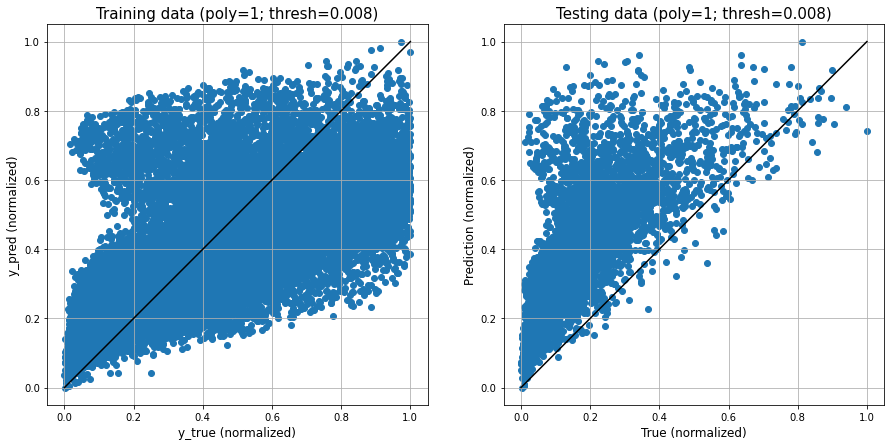

In [16]:
df_test = pd.read_csv("testing_set.csv", sep=";")
df_test_norm = pd.read_csv("testing_set_normalized.csv", sep=";")
df_test["y_norm"] = df_test_norm.y.copy()

model_1 = modelAuto(df, df_test, PolyDegree = 1, select_thresh=0.008)

### 4.1 Grid Search

In [17]:
# train
df_train = pd.read_csv("training_set.csv", sep=';')
df_train_normalized = pd.read_csv("training_set_normalized.csv", sep = ";")
df_train["y_norm"] = df_train_normalized.y.copy()

# test
df_test = pd.read_csv("testing_set.csv", sep=";")
df_test_normalized = pd.read_csv("testing_set_normalized.csv", sep=";")
df_test["y_norm"] = df_test_normalized.y.copy()

# lasso relative score for feature selection
thresholds = [0.0000, 0.0012, 0.0080, 0.0161, 0.0166, 0.0186, 0.0290, 0.0300, 0.0450]

##### 4.1.1 Polynomial degree: 1

Relative feature selection threshold: 0.0
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Training MAE: 0.5424043043509201
Testing MAE: 0.7468118702991361
Training R^2: 0.48336406409283095
Testing R^2: 0.4557051303520979


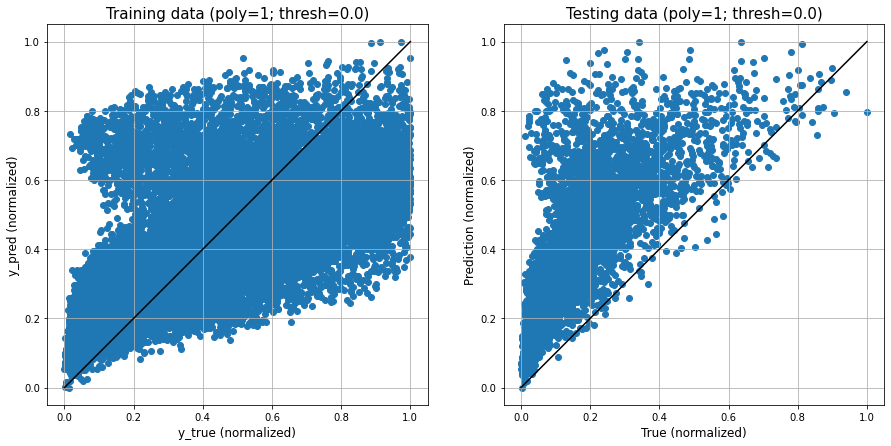


-----------------------
Relative feature selection threshold: 0.0012
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.5427201122951631
Testing MAE: 0.7498149443239888
Training R^2: 0.480794373926138
Testing R^2: 0.45065045198236586


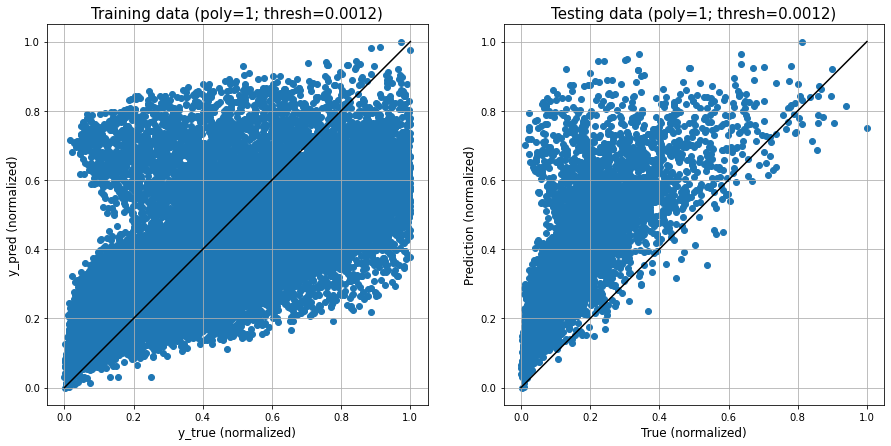


-----------------------
Relative feature selection threshold: 0.008
Selected features:
['hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.543022521214684
Testing MAE: 0.7506559504618218
Training R^2: 0.48052089550216837
Testing R^2: 0.4499315932893483


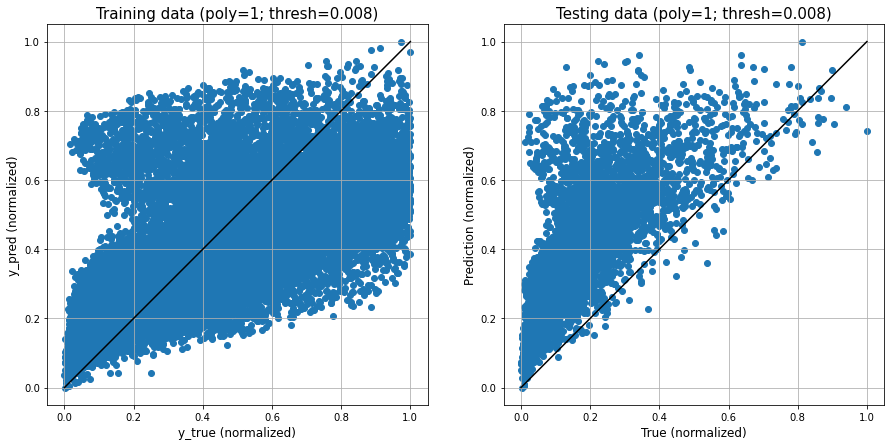


-----------------------
Relative feature selection threshold: 0.0161
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.5440777865793915
Testing MAE: 0.7546683093260189
Training R^2: 0.47947023849210135
Testing R^2: 0.4467074186705773


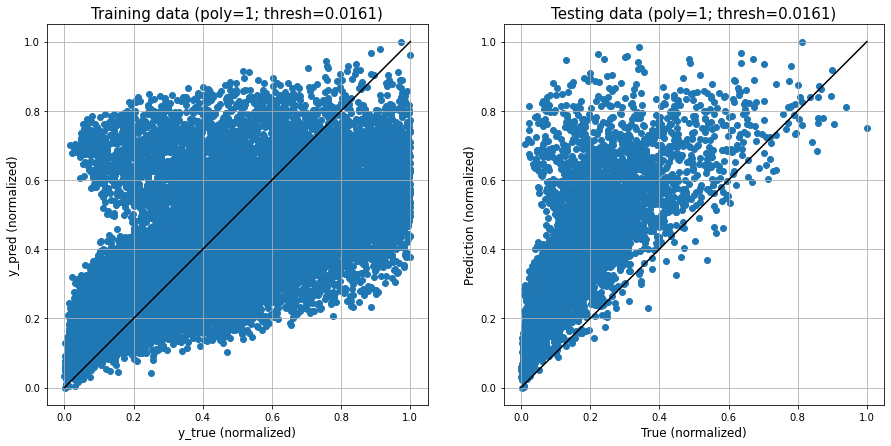


-----------------------
Relative feature selection threshold: 0.0166
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'flange_slenderness_1']
Training MAE: 0.5440627439837907
Testing MAE: 0.754662635752263
Training R^2: 0.4794580809862291
Testing R^2: 0.4466231605825498


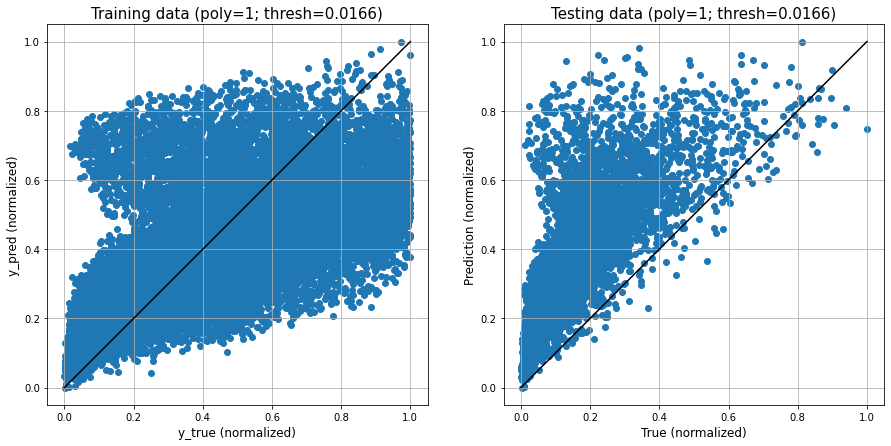


-----------------------
Relative feature selection threshold: 0.0186
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length']
Training MAE: 0.5439867827984645
Testing MAE: 0.7569531130014655
Training R^2: 0.4788242117607103
Testing R^2: 0.442716024305421


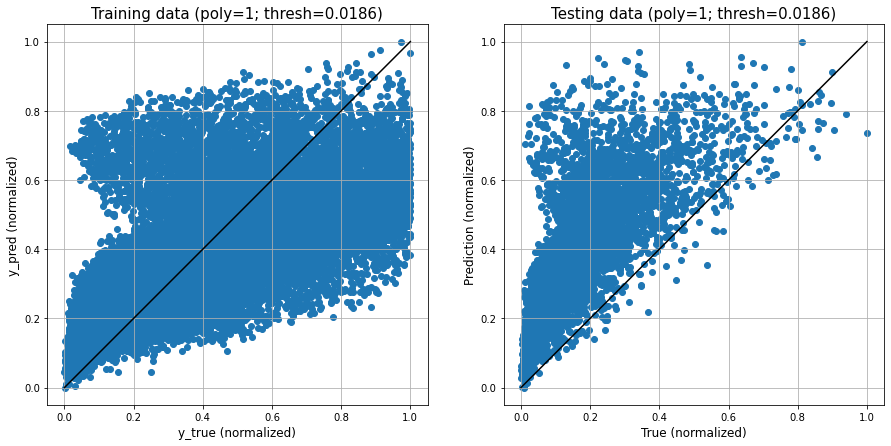


-----------------------
Relative feature selection threshold: 0.029
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'flange_width_ratio', 'beam_length']
Training MAE: 0.5450151696160138
Testing MAE: 0.7574712318574712
Training R^2: 0.4756170928995904
Testing R^2: 0.442016097901454


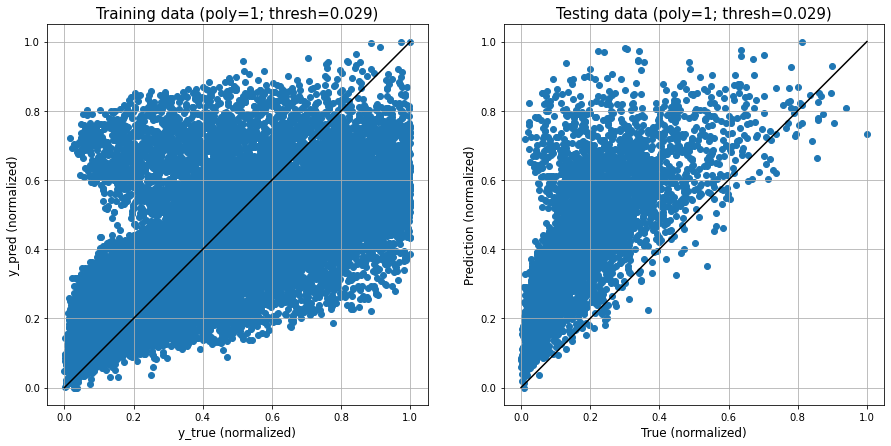


-----------------------
Relative feature selection threshold: 0.03
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.5452434698921662
Testing MAE: 0.7573442000193059
Training R^2: 0.47503544269823816
Testing R^2: 0.44234567828917004


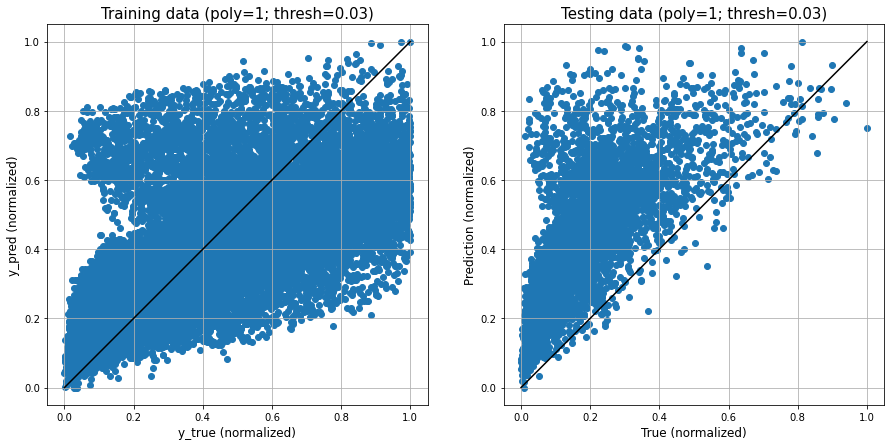


-----------------------
Relative feature selection threshold: 0.045
Selected features:
['tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.5491483350999606
Testing MAE: 0.7677857409664957
Training R^2: 0.4682995023261539
Testing R^2: 0.4294835455415842


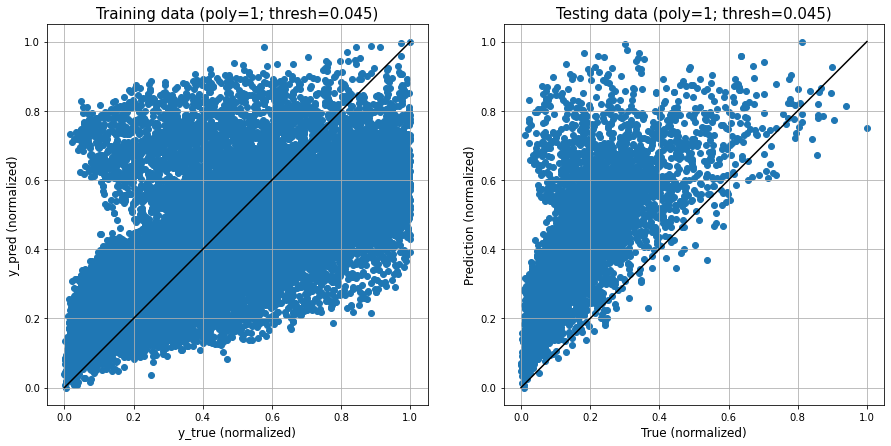


-----------------------


In [111]:
for thr in thresholds:
    print("Relative feature selection threshold:", thr)
    model = modelAuto(df_train, df_test, PolyDegree = 1, select_thresh = thr)
    print("")
    print("-----------------------")

##### 4.1.2 Polynomial degree: 2

Relative feature selection threshold: 0.0
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Training MAE: 0.3385481679630639
Testing MAE: 0.5246322858065869
Training R^2: 0.7993822276985749
Testing R^2: 0.6641277576697822


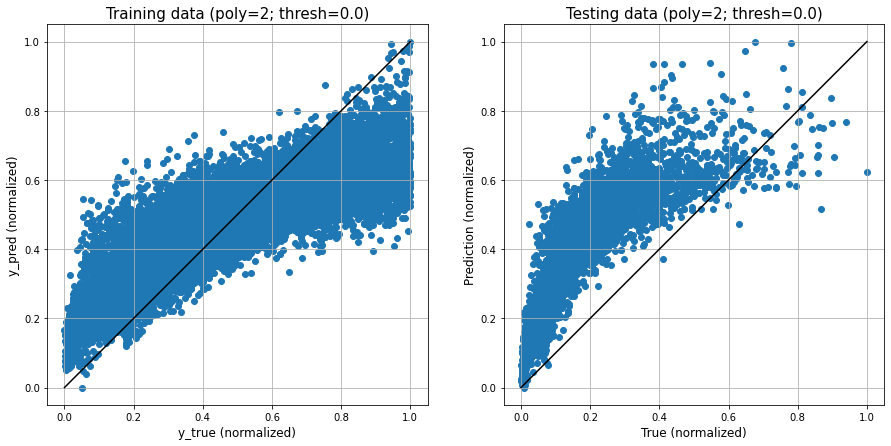


-----------------------
Relative feature selection threshold: 0.0012
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.43772237761838395
Testing MAE: 0.6347883755346806
Training R^2: 0.6799551310491645
Testing R^2: 0.594133244510695


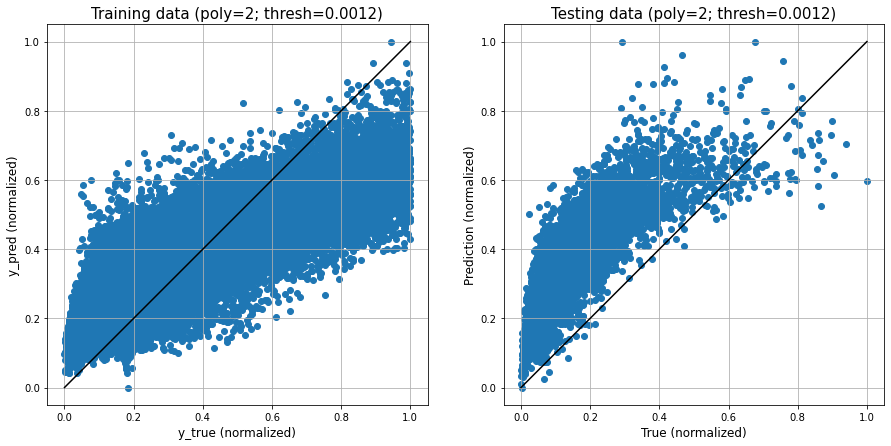


-----------------------
Relative feature selection threshold: 0.008
Selected features:
['hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.4408083969339133
Testing MAE: 0.6348502389999697
Training R^2: 0.6757786757337656
Testing R^2: 0.5953294354079537


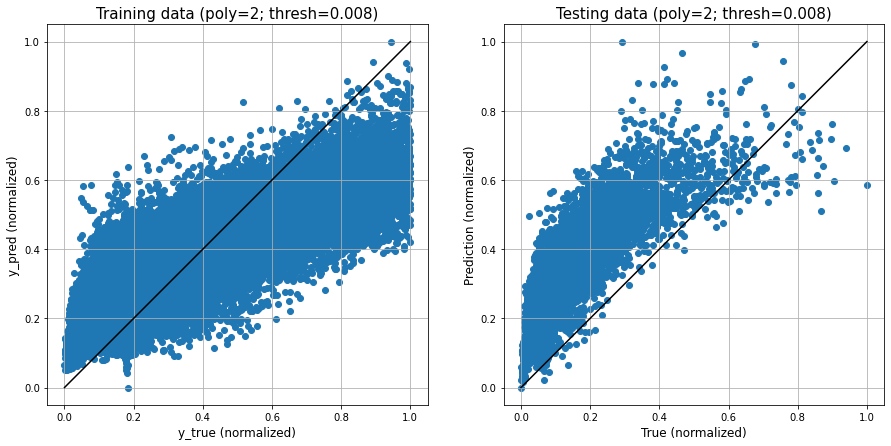


-----------------------
Relative feature selection threshold: 0.0161
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.4510291694912202
Testing MAE: 0.652255043760614
Training R^2: 0.6612049399179933
Testing R^2: 0.5647675396546219


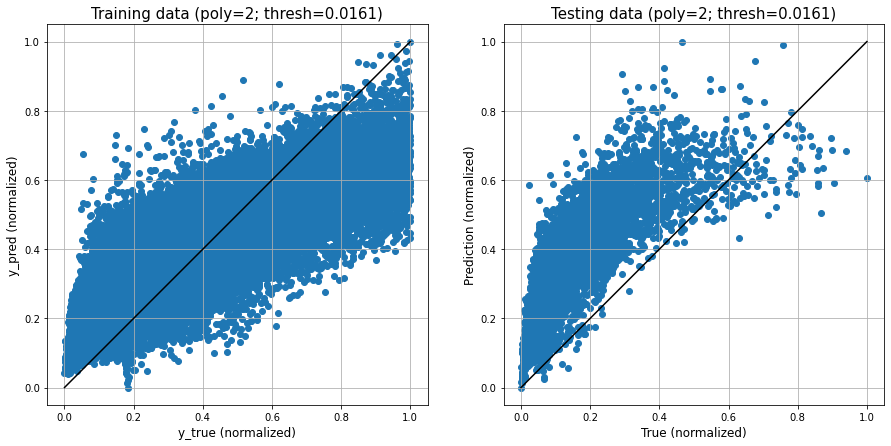


-----------------------
Relative feature selection threshold: 0.0166
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'flange_slenderness_1']
Training MAE: 0.45257689856280847
Testing MAE: 0.6569194760625351
Training R^2: 0.6582778607373718
Testing R^2: 0.5586165933327756


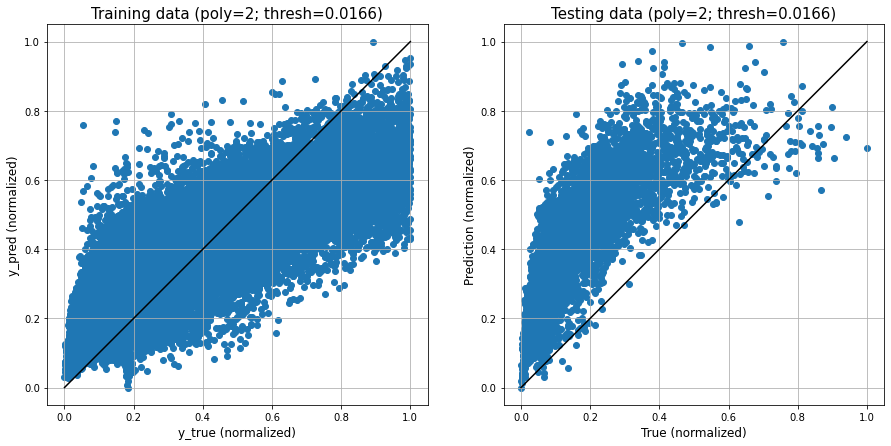


-----------------------
Relative feature selection threshold: 0.0186
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length']
Training MAE: 0.4613139129225435
Testing MAE: 0.6651962406641004
Training R^2: 0.6472205137292775
Testing R^2: 0.551694552684376


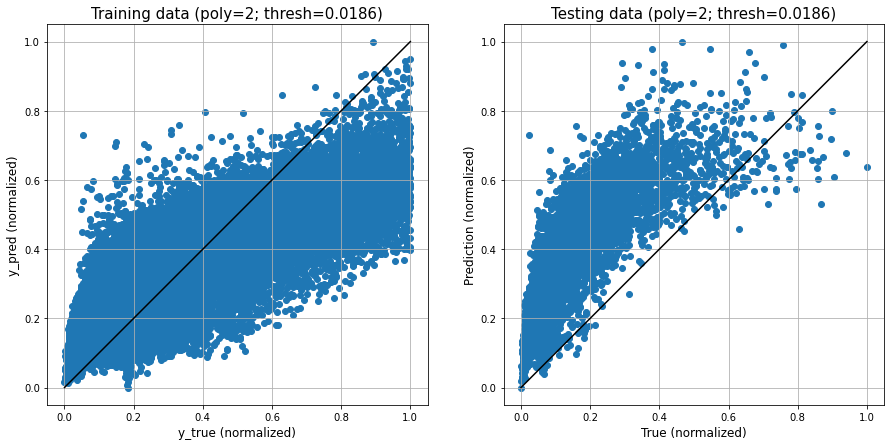


-----------------------
Relative feature selection threshold: 0.029
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'flange_width_ratio', 'beam_length']
Training MAE: 0.4644477947743515
Testing MAE: 0.6694040482877014
Training R^2: 0.6406757541437242
Testing R^2: 0.5460960313756384


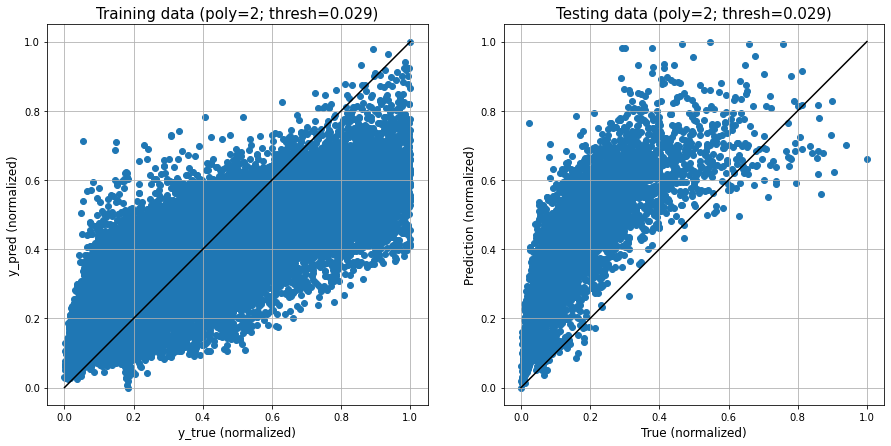


-----------------------
Relative feature selection threshold: 0.03
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.4655632338097295
Testing MAE: 0.6686539856815169
Training R^2: 0.6380961082869923
Testing R^2: 0.547454866951955


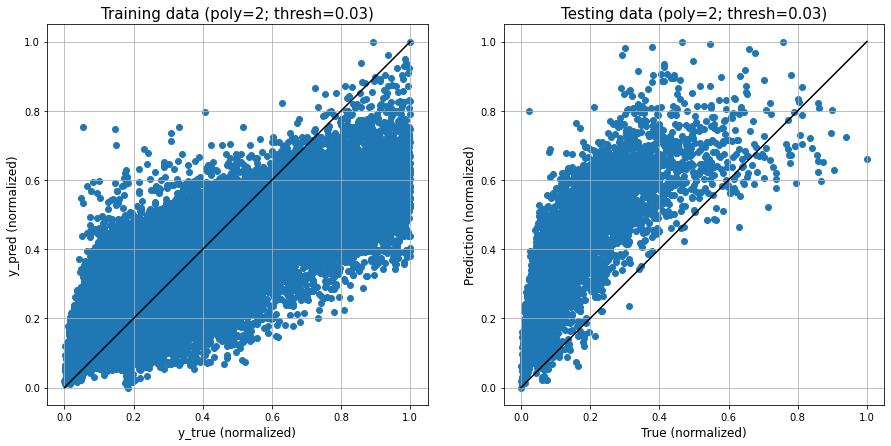


-----------------------
Relative feature selection threshold: 0.045
Selected features:
['tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.4736906516361394
Testing MAE: 0.6917600249206444
Training R^2: 0.6249949016601544
Testing R^2: 0.5137556625411783


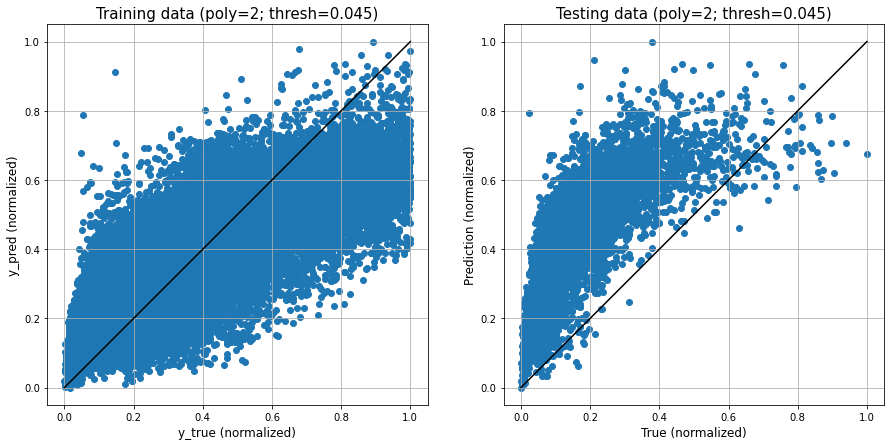


-----------------------


In [112]:
for thr in thresholds:
    print("Relative feature selection threshold:", thr)
    model = modelAuto(df_train, df_test, PolyDegree = 2, select_thresh = thr)
    print("")
    print("-----------------------")

##### 4.1.3 Polynomial degree: 3

Relative feature selection threshold: 0.0
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Training MAE: 0.18184507554158924
Testing MAE: 0.3029794385158454
Training R^2: 0.9347573141676953
Testing R^2: 0.8635127065721049


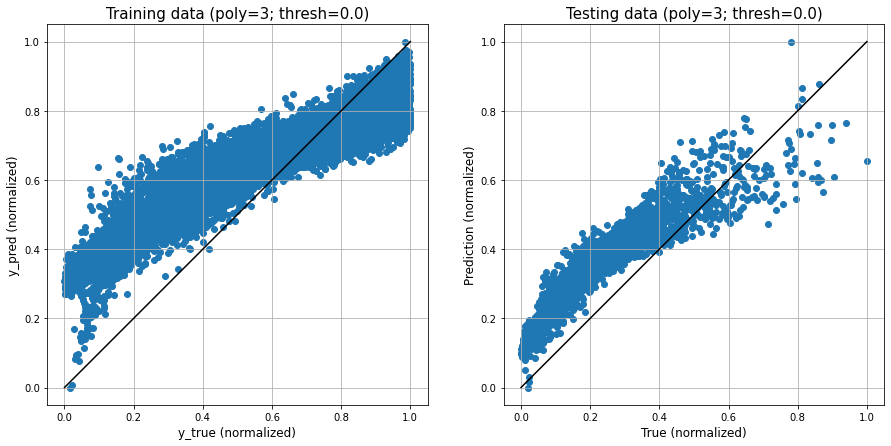


-----------------------
Relative feature selection threshold: 0.0012
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.3289636913165862
Testing MAE: 0.49027351152091475
Training R^2: 0.7984238015957082
Testing R^2: 0.7559440788569862


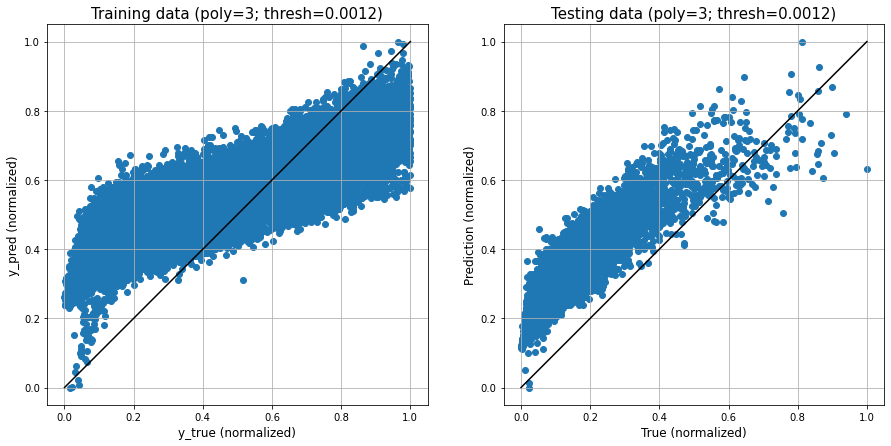


-----------------------
Relative feature selection threshold: 0.008
Selected features:
['hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.3334171760757929
Testing MAE: 0.49316237202224594
Training R^2: 0.7945779724322548
Testing R^2: 0.755694550121385


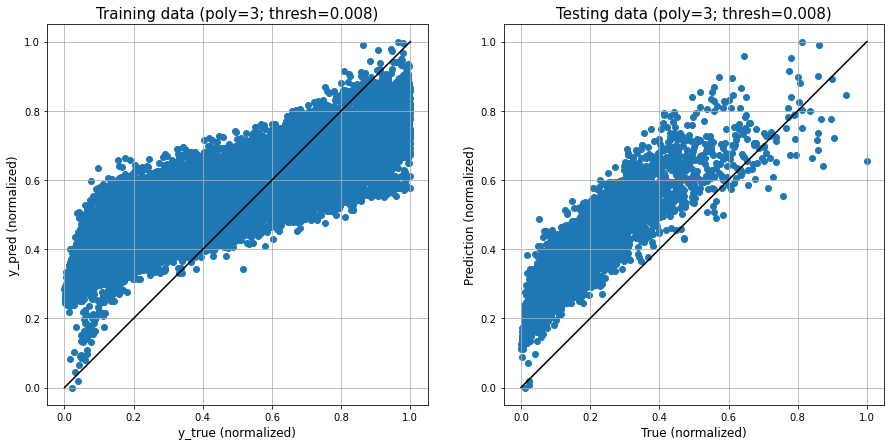


-----------------------
Relative feature selection threshold: 0.0161
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.3577129153074803
Testing MAE: 0.5329335098541573
Training R^2: 0.7649606968905441
Testing R^2: 0.7050253079186983


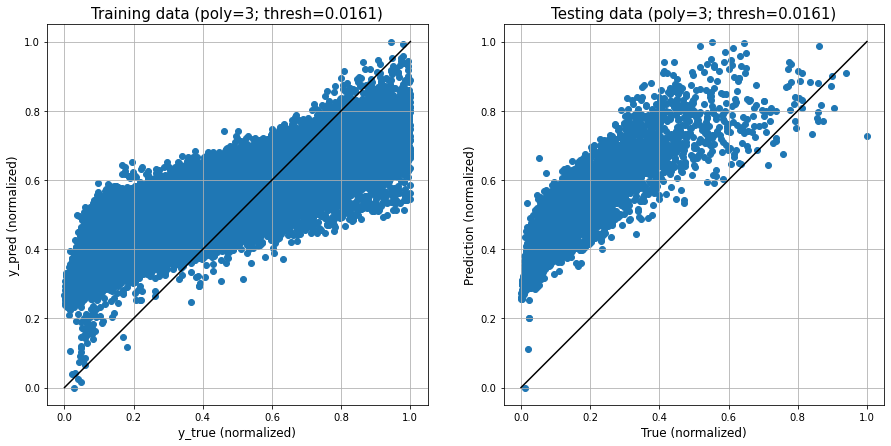


-----------------------
Relative feature selection threshold: 0.0166
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'flange_slenderness_1']
Training MAE: 0.35576631355248634
Testing MAE: 0.5306034712001155
Training R^2: 0.7659937415250601
Testing R^2: 0.7075799783272909


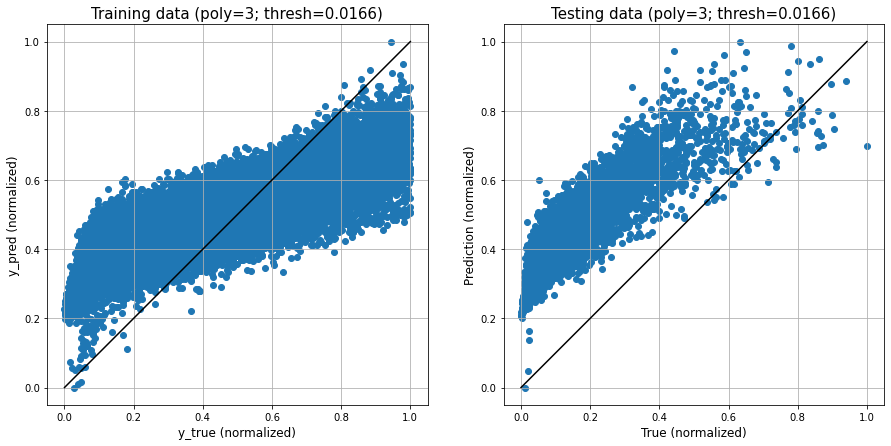


-----------------------
Relative feature selection threshold: 0.0186
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length']
Training MAE: 0.3582539035847087
Testing MAE: 0.5345240370521648
Training R^2: 0.762298884832117
Testing R^2: 0.7030133518356412


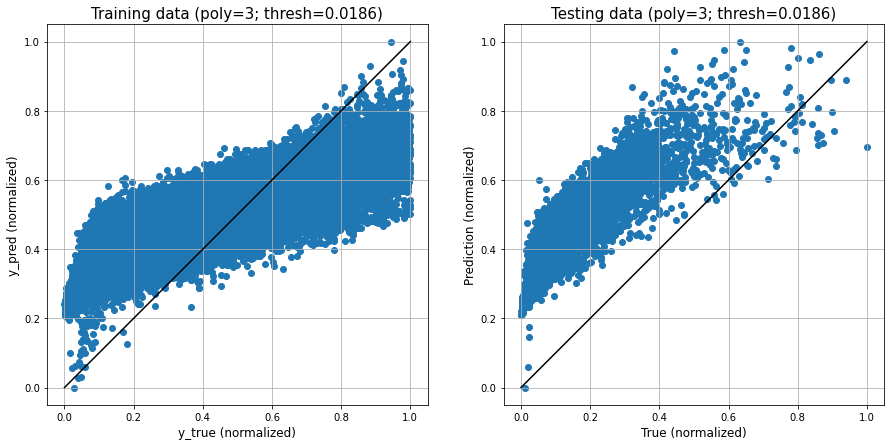


-----------------------
Relative feature selection threshold: 0.029
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'flange_width_ratio', 'beam_length']
Training MAE: 0.36543819404235545
Testing MAE: 0.5436424823654851
Training R^2: 0.751146004201092
Testing R^2: 0.6919200075046577


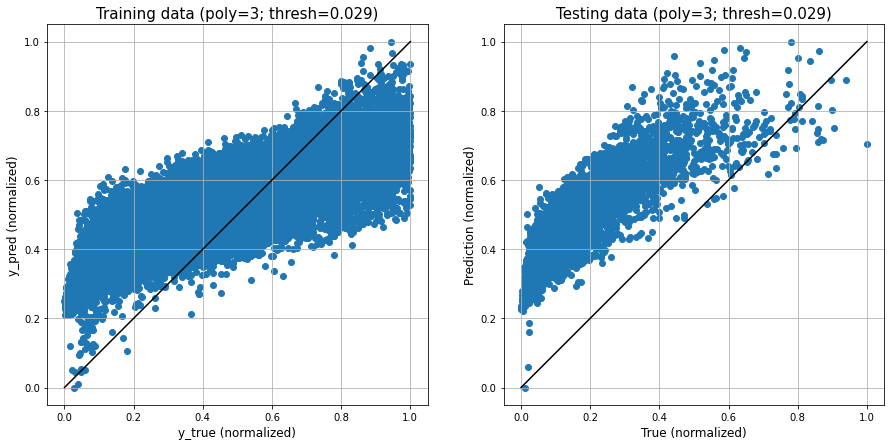


-----------------------
Relative feature selection threshold: 0.03
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.3697378949849734
Testing MAE: 0.5471400540443437
Training R^2: 0.7428216458822654
Testing R^2: 0.6846002544125942


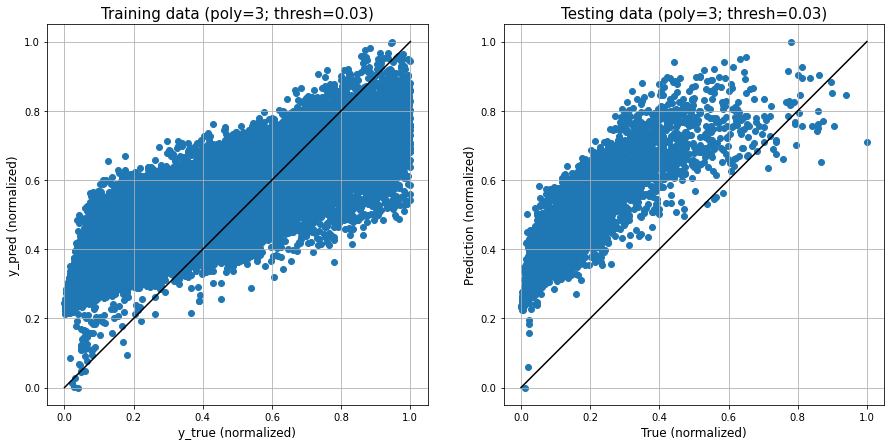


-----------------------
Relative feature selection threshold: 0.045
Selected features:
['tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.3905676922316806
Testing MAE: 0.5949178580818051
Training R^2: 0.7121471389549536
Testing R^2: 0.6270308247473622


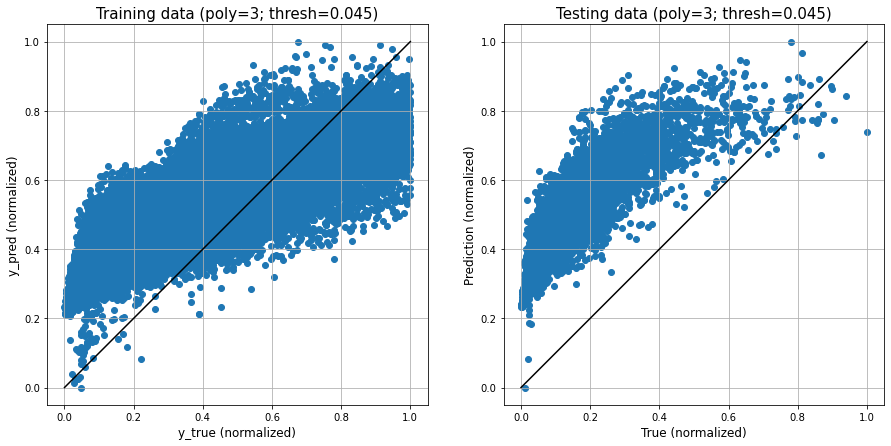


-----------------------


In [113]:
for thr in thresholds:
    print("Relative feature selection threshold:", thr)
    model = modelAuto(df_train, df_test, PolyDegree = 3, select_thresh = thr)
    print("")
    print("-----------------------")

##### 4.1.4 Polynomial degree: 4

Relative feature selection threshold: 0.0
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Training MAE: 0.1121693140488222
Testing MAE: 0.2331468050188898
Training R^2: 0.9723927383712168
Testing R^2: 0.8980947736580981


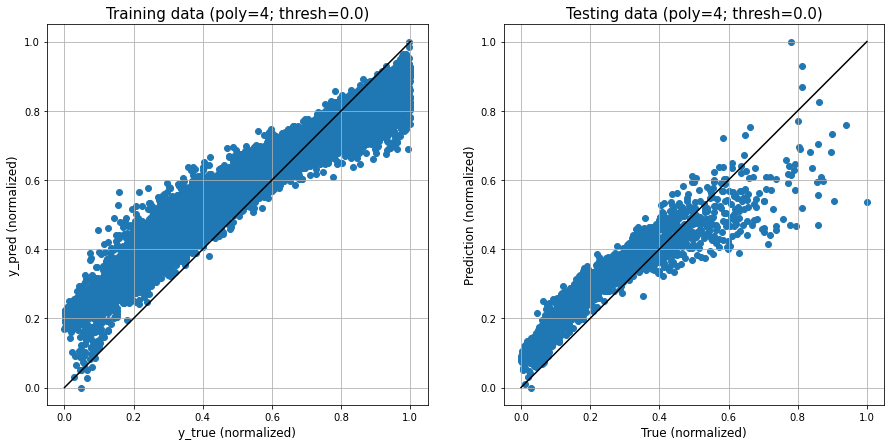


-----------------------
Relative feature selection threshold: 0.0012
Selected features:
['hw1', 'hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.28703274315081534
Testing MAE: 0.44675344683129703
Training R^2: 0.8357010452211249
Testing R^2: 0.7960789271766664


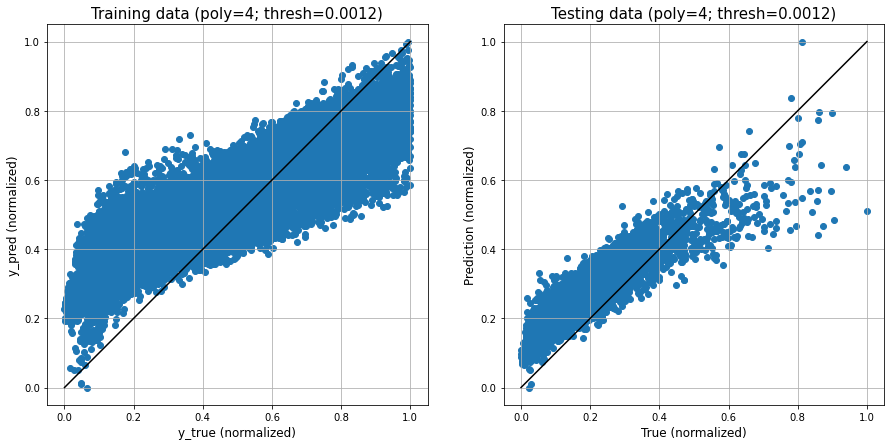


-----------------------
Relative feature selection threshold: 0.008
Selected features:
['hw2', 'tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.2877963195792507
Testing MAE: 0.4450110520262005
Training R^2: 0.8346852822793451
Testing R^2: 0.7939429949368135


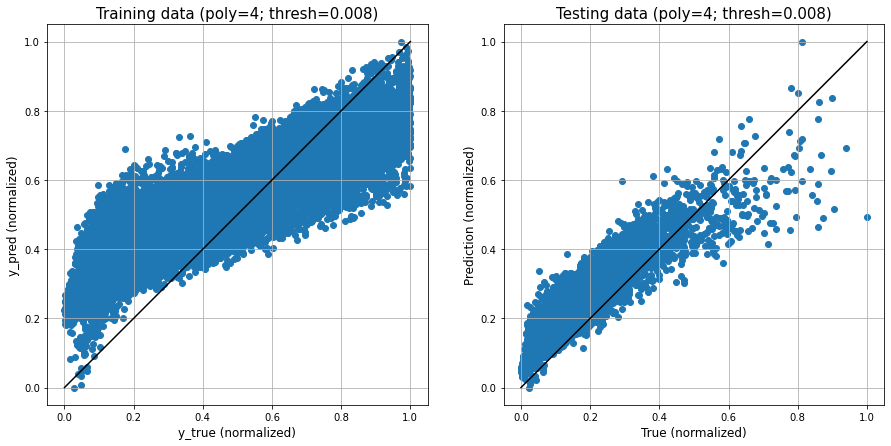


-----------------------
Relative feature selection threshold: 0.0161
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'flange_slenderness_1']
Training MAE: 0.3167015816902205
Testing MAE: 0.4992055740310697
Training R^2: 0.8035169620601703
Testing R^2: 0.7213179208009198


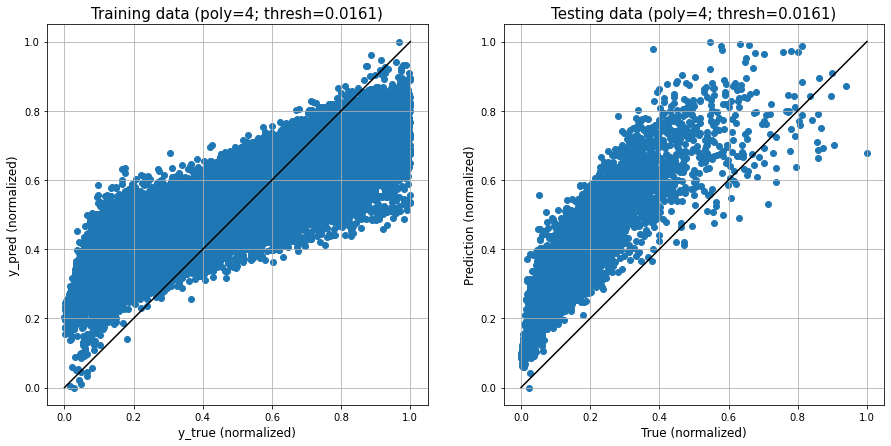


-----------------------
Relative feature selection threshold: 0.0166
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length', 'flange_slenderness_1']
Training MAE: 0.3163214328160436
Testing MAE: 0.49901464542380447
Training R^2: 0.8027007226018599
Testing R^2: 0.7201676413989571


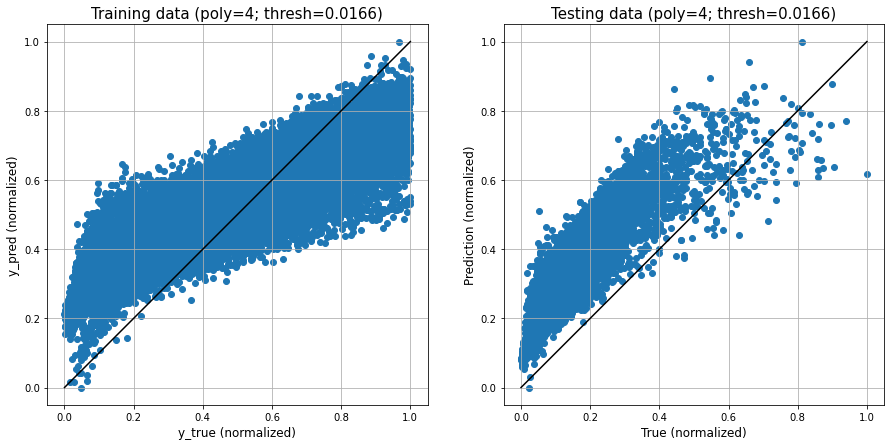


-----------------------
Relative feature selection threshold: 0.0186
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'beam_length']
Training MAE: 0.32019937065364695
Testing MAE: 0.5002517282565958
Training R^2: 0.7982538105097075
Testing R^2: 0.7226064192909729


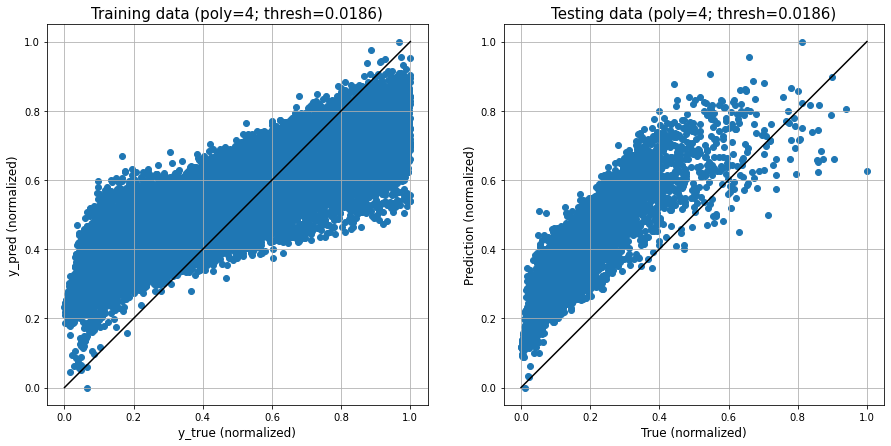


-----------------------
Relative feature selection threshold: 0.029
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'L', 'flange_width_ratio', 'beam_length']
Training MAE: 0.33114279705593996
Testing MAE: 0.51557562099689
Training R^2: 0.7845150266236517
Testing R^2: 0.7052583017588281


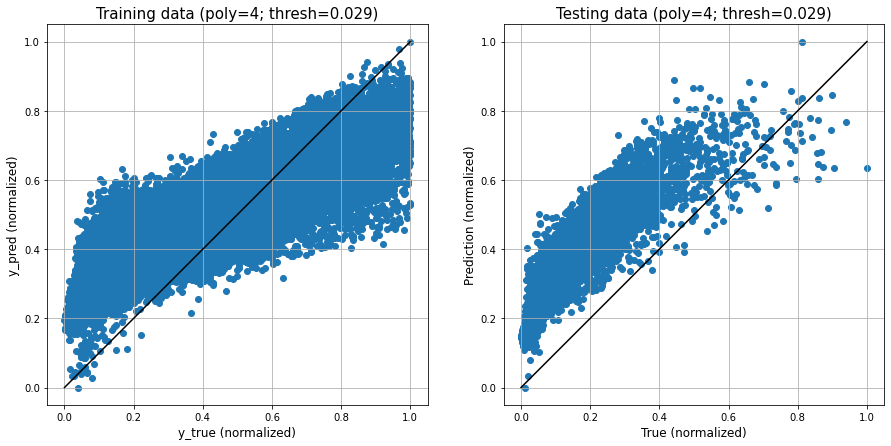


-----------------------
Relative feature selection threshold: 0.03
Selected features:
['tw', 'tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.33563323983770166
Testing MAE: 0.517321285773335
Training R^2: 0.7795114077681715
Testing R^2: 0.7062219364831475


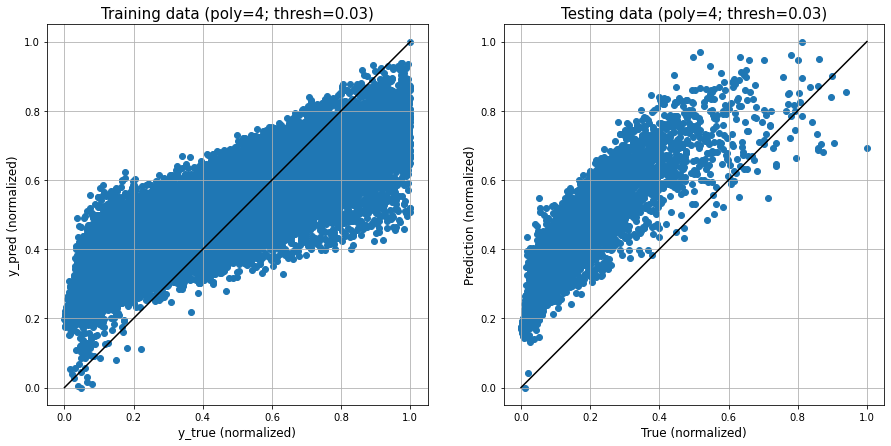


-----------------------
Relative feature selection threshold: 0.045
Selected features:
['tf1', 'bf2', 'psi', 'flange_width_ratio', 'beam_length']
Training MAE: 0.3567796705402749
Testing MAE: 0.5709180490833331
Training R^2: 0.7480809805779851
Testing R^2: 0.6347325335056604


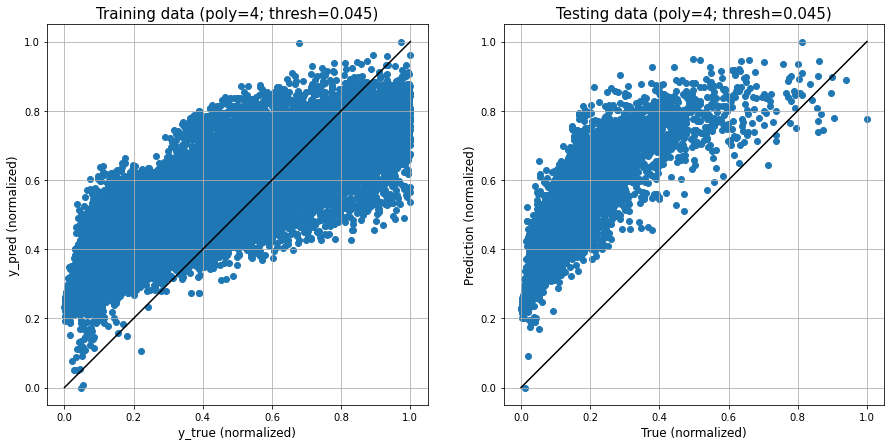


-----------------------


In [114]:
for thr in thresholds:
    print("Relative feature selection threshold:", thr)
    model = modelAuto(df_train, df_test, PolyDegree = 4, select_thresh = thr)
    print("")
    print("-----------------------")

##### 4.1.5 Polynomial degree: 5

<br> For polynomial degrees of higher order, we have chosen not to do a grid search for the best threshold for feature selection, since running time would be too long and it has been proven that the regression has a better performance with all features. </br>
<br> However, this strategy will overflow the memory of the computer, so we are running in next cell a fraction (1/20) of the original training and testing datasets.

Lasso regression alpha: 1e-06
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.130e+00, tolerance: 3.151e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.041049923991939484
Testing MAE: 0.3506836398024813
Training R^2: 0.9962037202928868
Testing R^2: 0.8716852412591501


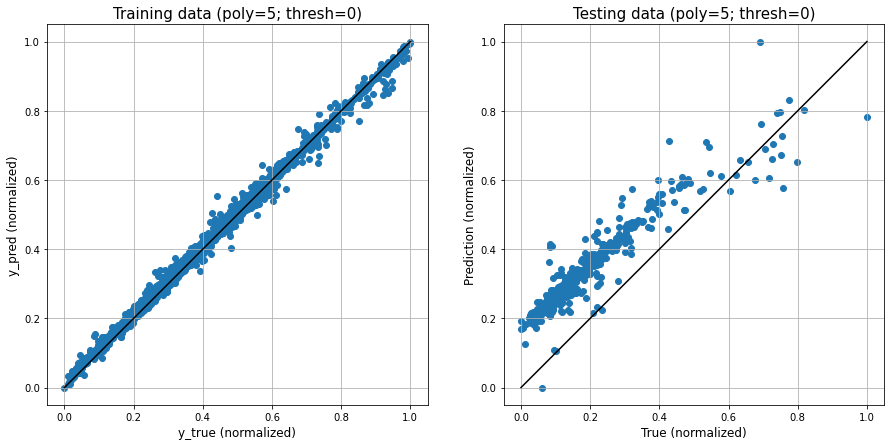


-----------------------
Lasso regression alpha: 1e-05
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.408e+01, tolerance: 3.151e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.04400596943882607
Testing MAE: 0.33397863578799514
Training R^2: 0.9955987950285067
Testing R^2: 0.8794661974913358


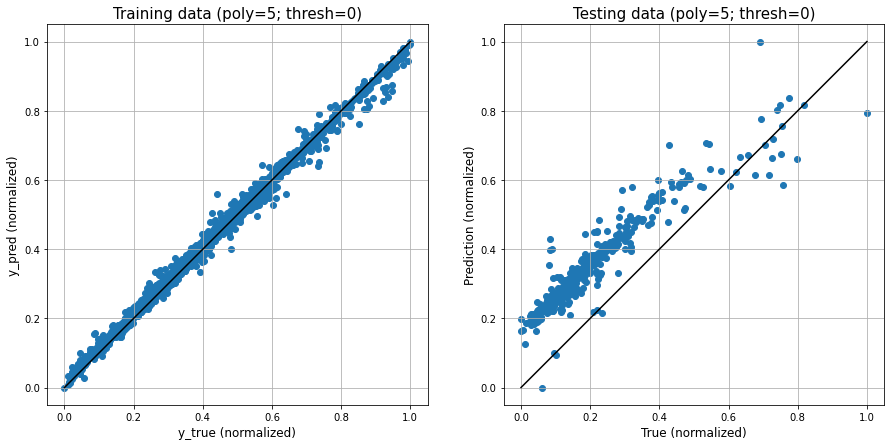


-----------------------
Lasso regression alpha: 0.0001
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.857e+01, tolerance: 3.151e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.07063431266388935
Testing MAE: 0.27489545204966387
Training R^2: 0.9888593069121411
Testing R^2: 0.9090215080314129


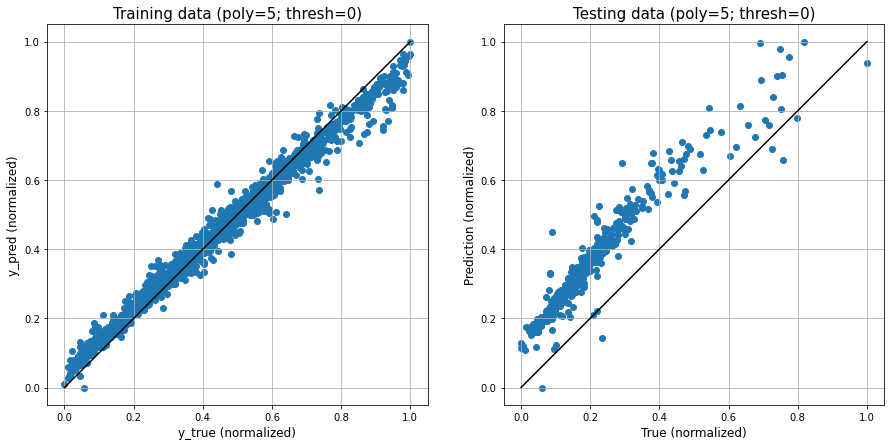


-----------------------
Lasso regression alpha: 0.0005
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.161e+01, tolerance: 3.151e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.11468767045462432
Testing MAE: 0.27070695572737846
Training R^2: 0.9721066433494916
Testing R^2: 0.9174493077622208


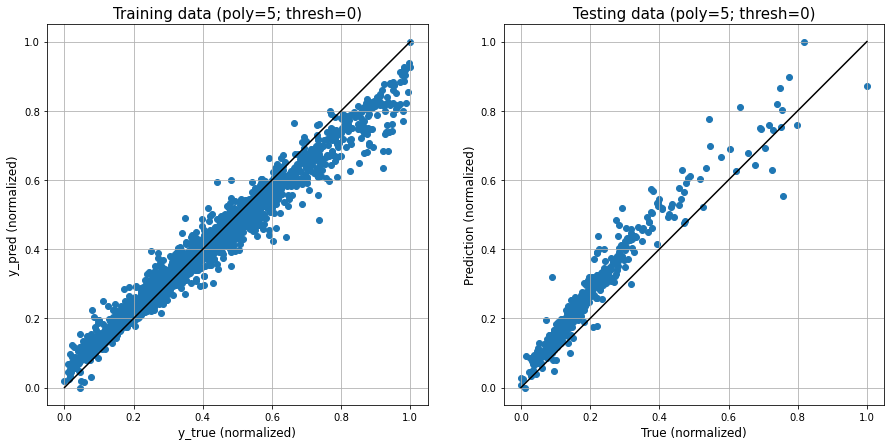


-----------------------
Lasso regression alpha: 0.001
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.427e+01, tolerance: 3.151e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.14052916189590398
Testing MAE: 0.2824563055140886
Training R^2: 0.9586498997276969
Testing R^2: 0.9124453232391049


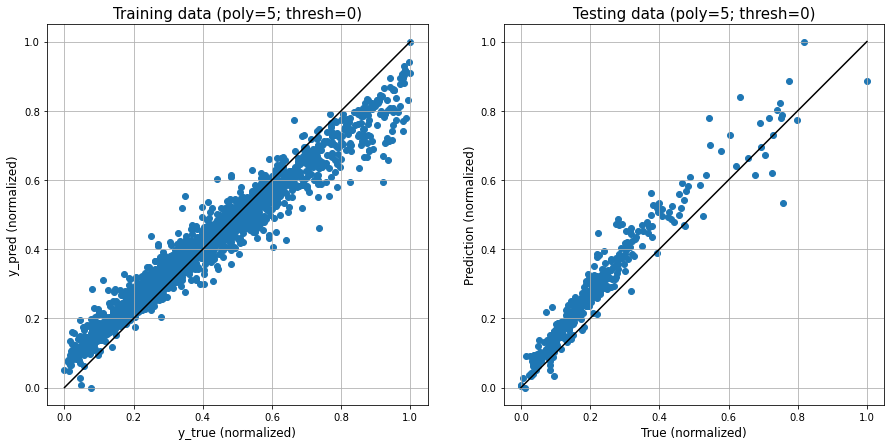


-----------------------
Lasso regression alpha: 0.005
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.880e+00, tolerance: 3.151e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.22592844684728305
Testing MAE: 0.37859257793628104
Training R^2: 0.9014963177754185
Testing R^2: 0.8581452949386192


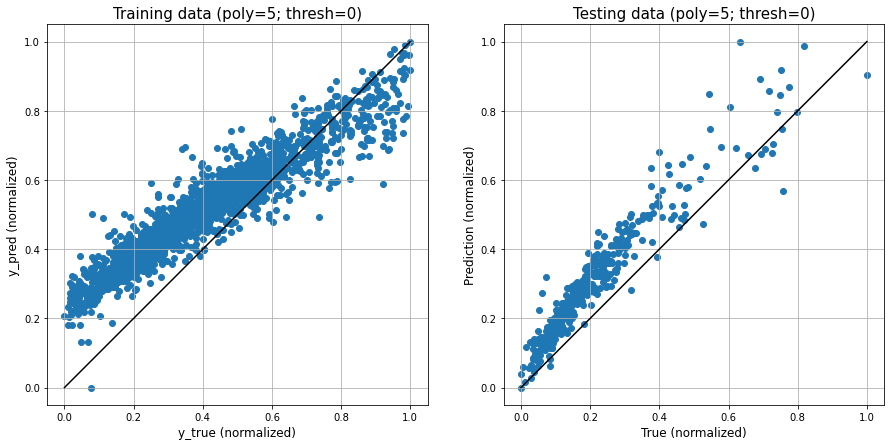


-----------------------
Lasso regression alpha: 0.01
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']


c:\Users\Miguel Silva\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.214e-01, tolerance: 3.151e-01
  model = cd_fast.enet_coordinate_descent(


Training MAE: 0.27504964301751733
Testing MAE: 0.44846601363764316
Training R^2: 0.8609033377127439
Testing R^2: 0.8100335228948297


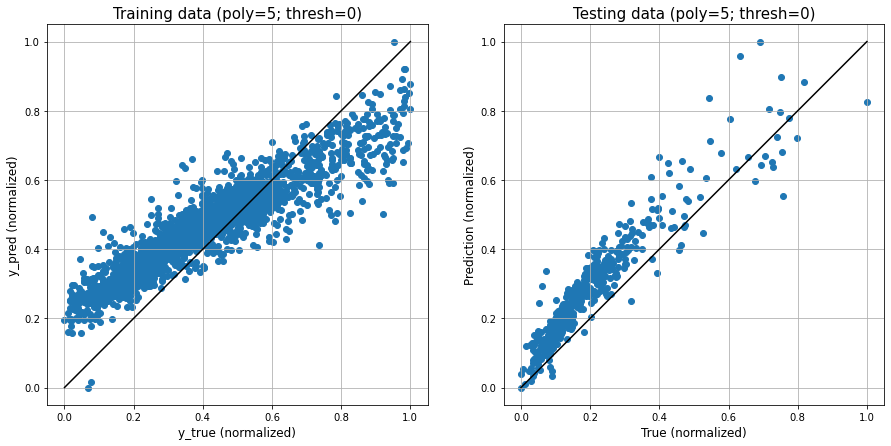


-----------------------
Lasso regression alpha: 0.05
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Training MAE: 0.4353796543389033
Testing MAE: 0.6800288517429081
Training R^2: 0.6794866670516653
Testing R^2: 0.5987921043240535


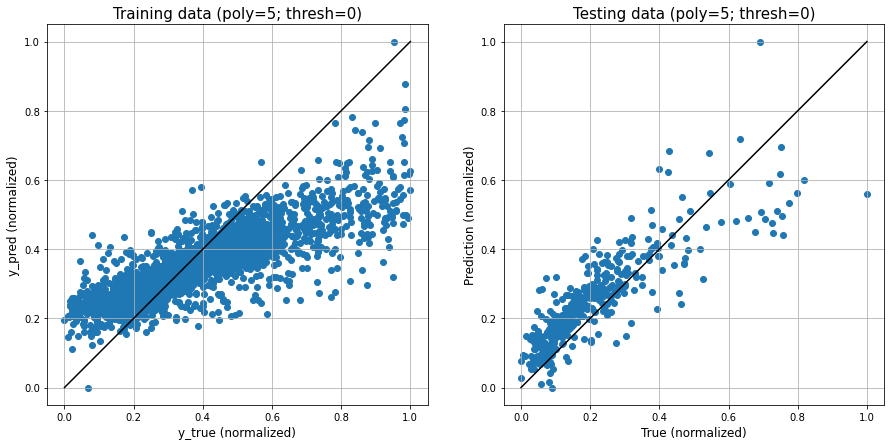


-----------------------
Lasso regression alpha: 0.1
Selected features:
['hw1', 'hw2', 'tw', 'bf1', 'tf1', 'bf2', 'tf2', 'psi', 'L', 'taper_ratio', 'flange_width_ratio', 'height_to_width_ratio', 'beam_length', 'plate_thickness_ratio_1', 'plate_thickness_ratio_2', 'flange_slenderness_1', 'flange_slenderness_2', 'web_slenderness']
Training MAE: 0.5087728470293453
Testing MAE: 0.7858738145464779
Training R^2: 0.5760085404904174
Testing R^2: 0.4826758493330867


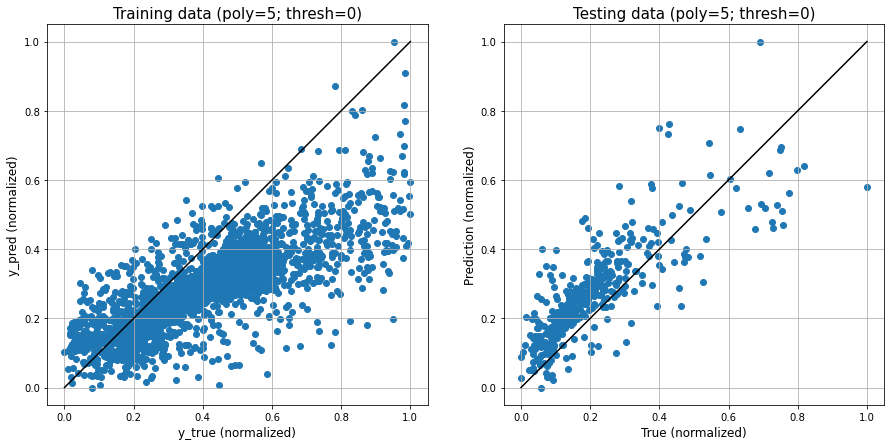


-----------------------


In [18]:
# train
df_train_5 = df_train.copy().sample(frac=1/20, ignore_index=True)
# test
df_test_5 = df_test.copy().sample(frac=1/20, ignore_index=True)

for alpha in [0.000001, 0.00001, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1]:
    print("Lasso regression alpha:", alpha)
    model = modelAuto(df_train_5, df_test_5, PolyDegree = 5, select_thresh = 0, alpha = alpha)
    print("")
    print("-----------------------")

# thr = 0
# print("Relative feature selection threshold:", thr)
# model = modelAuto(df_train_5, df_test_5, PolyDegree = 5, select_thresh = thr)